In [1]:
!pip install mtcnn

     |████████████████████████████████| 2.3 MB 534 kB/s 


In [2]:
import os, random
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import matplotlib.pyplot as plt
import seaborn as sns

import cv2
from mtcnn import MTCNN

print("Tensorflow :", tf.__version__)

Tensorflow : 2.6.0


In [3]:
SEED = 2021
SIZE = (256, 256)
BATCH_SIZE = 32
FACE_THRESHOLD = 0.85
FACE_DETECTOR = MTCNN()

2021-10-28 14:09:09.110521: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-28 14:09:09.213747: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-28 14:09:09.214843: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-28 14:09:09.216416: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [4]:
train = pd.read_csv("../input/bdc-2021/train.csv")
test = pd.read_csv("../input/bdc-2021/submission.csv")
train.head()

,nomor,jenis kelamin,usia
0,1,0,27
1,2,1,24
2,3,0,29
3,4,1,23
4,5,0,20


In [5]:
images = []
labels = []
test_images = []

TRAIN_DIR = "../input/bdc-2021/Training"
TEST_DIR = "../input/bdc-2021/Testing"

for no, label in train[["nomor", "jenis kelamin"]].values:
    TEMP_DIR = os.path.join(TRAIN_DIR, str(no))
    for file in os.listdir(TEMP_DIR):
        file_dir = os.path.join(TEMP_DIR, file)
        if ".ini" not in file_dir:
            images.append(file_dir)
            labels.append(label)

for no in test.id.values:
    file_dir = os.path.join(TEST_DIR, f"{no}.jpg")
    if os.path.isfile(file_dir):
        test_images.append(file_dir)
    else:
        test_images.append(None)
        print(file_dir)

In [6]:
def read(path):
    """
    Read data gambar
    """
    img = Image.open(path)
    return img

def show_images(list_dir, label = None, load_image = read, seed = SEED):
    """
    Menampilkan Gambar Secara acak sebanyak 5 buah.
    """
    random.seed(seed)
    unique = ["init"]
    if label:
        unique = list(set(label))
    fig, axes = plt.subplots(len(unique), 5, figsize = (20, 5 * len(unique)))
    for i in range(len(unique)):
        if i == 0 and unique[i] == "init":
            data = random.sample(list_dir, 5)
        else:
            data = random.sample([x for x in zip(list_dir, label) if x[1] == unique[i]], 5)
        for j in range(5):
            if unique[0] != "init":
                img = load_image(data[j][0])
                axes[i, j].imshow(img)
                axes[i, j].set_title(f'Label : {data[j][1]}', fontsize = 14)
                axes[i, j].axis('off')
            else:
                img = load_image(data[j])
                axes[j].imshow(img)
                axes[j].axis('off')
    fig.tight_layout()
    plt.show()

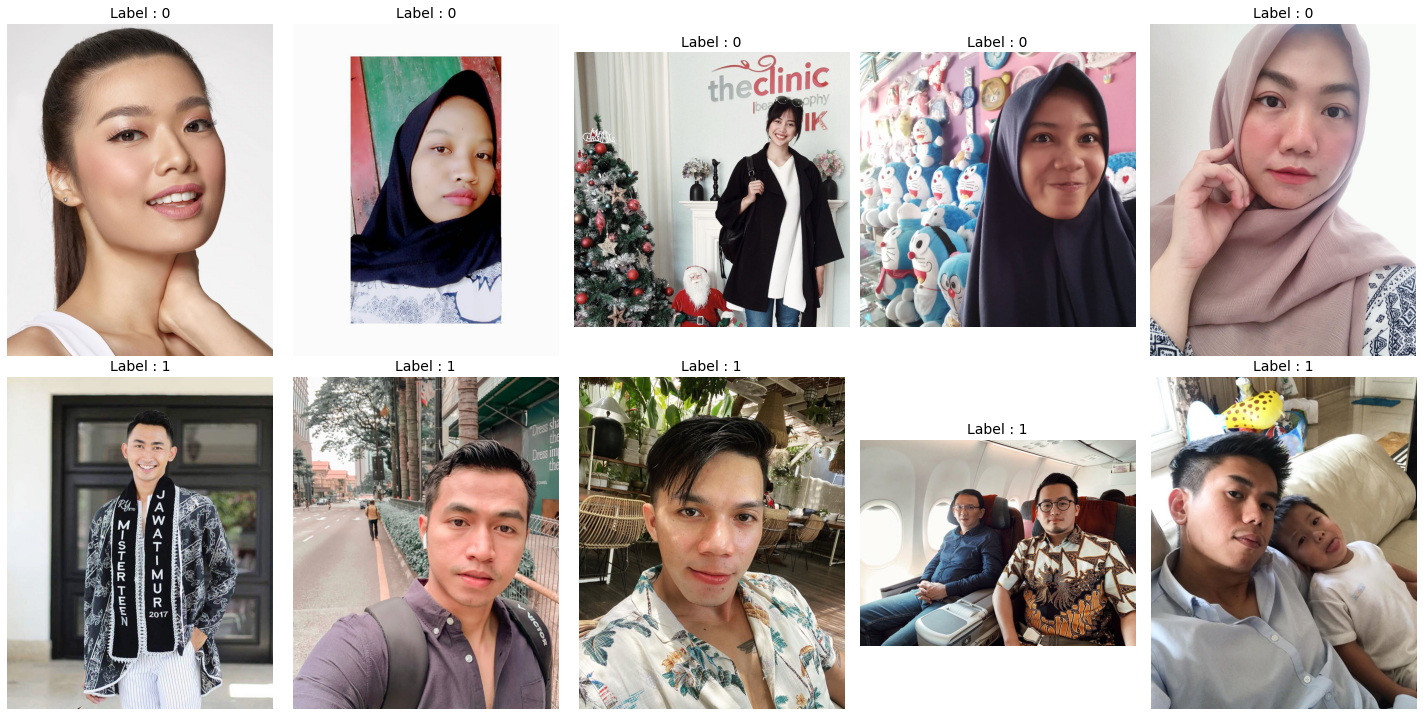

In [7]:
show_images(images, labels, seed= 20)

In [8]:
def get_faces(path):
    image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    faces = FACE_DETECTOR.detect_faces(image)
    return faces

def load_and_preprocess_image(path: str, size = SIZE):
    """
    Load & Preprocess data gambar
    """
    image = img_to_array(load_img(path))
    faces = [x['box'] for x in get_faces(path) if x['confidence'] > FACE_THRESHOLD]
    if len(faces) > 0:
        x, y, w, h = faces[0]
        image = image[y:y+h, x:x+w]
    img = tf.convert_to_tensor(image, dtype=tf.float32)
    if len(faces) == 0:
        shapes = tf.shape(img)
        h, w = shapes[-3], shapes[-2]
        dim = tf.minimum(h, w)
        img = tf.image.resize_with_crop_or_pad(img, dim, dim)
    img = tf.image.resize(img, size)
    img = tf.cast(img, tf.float32) / 255.0
    return img.numpy()

2021-10-28 14:09:20.864527: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-28 14:09:21.923755: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


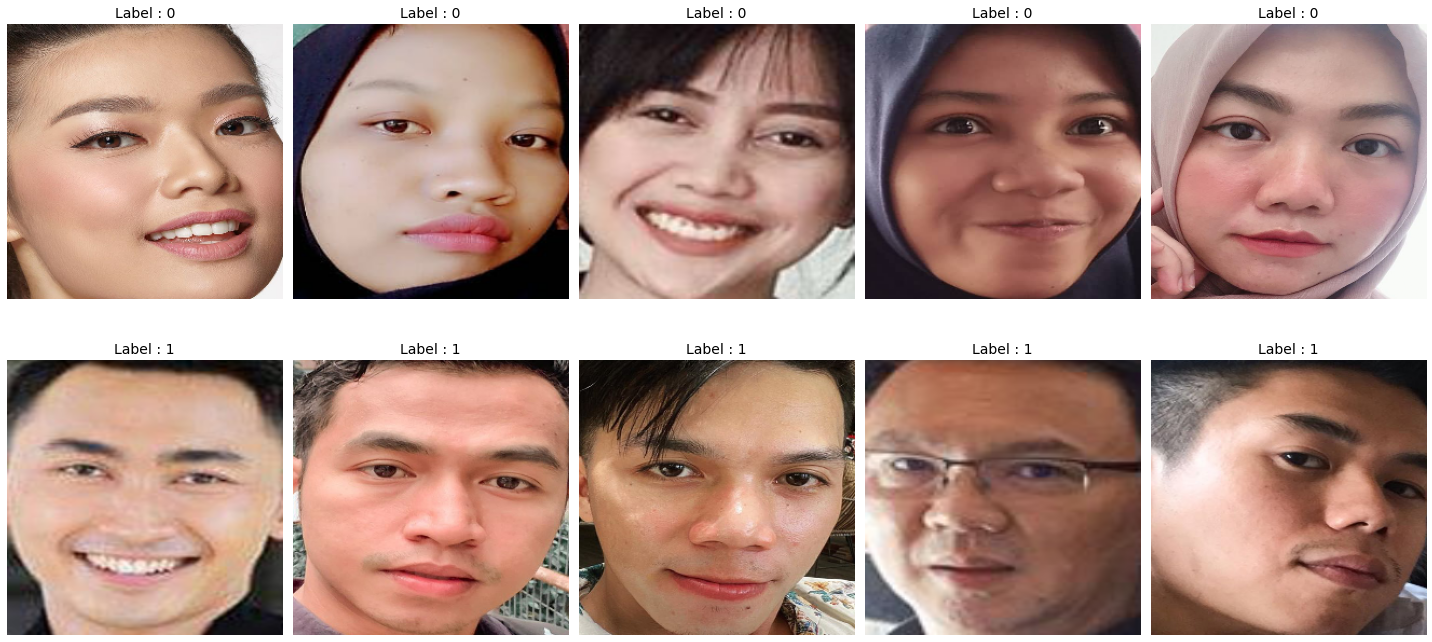

In [9]:
show_images(images, labels, load_image = load_and_preprocess_image, seed=20)

In [10]:
def image_preprocessing(new_dir, images, labels=None):
    if os.path.isdir(new_dir):
        !rm -rf {new_dir}
    os.mkdir(new_dir)
    
    new_images, new_labels = [], []
    if not labels:
        labels = [None for _ in range(len(images))]
    
    for path, label in tqdm(zip(images, labels), total=len(images)):
        image = img_to_array(load_img(path))
        faces = [x['box'] for x in sorted(get_faces(path), key=lambda x: x['confidence'], 
                                          reverse=True) if x['confidence'] > FACE_THRESHOLD]
        if len(faces) > 0:
            if label:
                for j, (x, y, w, h) in enumerate(faces):
                    img = image[y:y+h, x:x+w]
                    img = tf.convert_to_tensor(img, dtype=tf.float32)
                    img = tf.image.resize(img, SIZE)

                    img_dir = os.path.join(new_dir, f'{j}_{path.split("/")[-1]}')
                    new_images.append(img_dir)
                    new_labels.append(label)
                    tf.keras.preprocessing.image.save_img(img_dir, img)
            else:
                x, y, w, h = faces[0]
                img = image[y:y+h, x:x+w]
                img = tf.convert_to_tensor(img, dtype=tf.float32)
                img = tf.image.resize(img, SIZE)
                
                img_dir = os.path.join(new_dir, path.split('/')[-1])
                new_images.append(img_dir)
                new_labels.append(label)
                tf.keras.preprocessing.image.save_img(img_dir, img)
        else :
            img = tf.convert_to_tensor(image, dtype=tf.float32)
            shapes = tf.shape(img)
            h, w = shapes[-3], shapes[-2]
            dim = tf.minimum(h, w)
            img = tf.image.resize_with_crop_or_pad(img, dim, dim)
            img = tf.image.resize(img, SIZE)

            img_dir = os.path.join(new_dir, path.split('/')[-1])
            new_images.append(img_dir)
            new_labels.append(label)
            tf.keras.preprocessing.image.save_img(img_dir, img)
    
    return new_images, new_labels

In [11]:
new_train_dir = "./train"
new_test_dir = "./test"

new_images, new_labels = image_preprocessing(new_train_dir, images, labels)
new_test_images, _ = image_preprocessing(new_test_dir, test_images)

  0%|          | 0/2310 [00:00<?, ?it/s]

  0%|          | 0/990 [00:00<?, ?it/s]

In [12]:
preprocessed = pd.DataFrame({"image" : new_images, "label" : new_labels})
preprocessed.to_csv("preprocessed.csv", index=False)

In [13]:
!zip -r preprocessed.zip {new_train_dir} {new_test_dir}
!rm -rf {new_train_dir} {new_test_dir}

  adding: train/ (stored 0%)
  adding: train/235_2.jpg (deflated 2%)
  adding: train/2_155_1.jpg (deflated 5%)
  adding: train/0_562_1.jpg (deflated 2%)
  adding: train/1_677_3.jpg (deflated 4%)
  adding: train/0_357_2.jpg (deflated 2%)
  adding: train/0_684_3.jpg (deflated 1%)
  adding: train/622_1.jpg (deflated 2%)
  adding: train/0_16_2.jpg (deflated 2%)
  adding: train/1_53_1.jpg (deflated 2%)
  adding: train/1_478_3.jpg (deflated 1%)
  adding: train/334_2.jpg (deflated 2%)
  adding: train/413_2.jpg (deflated 1%)
  adding: train/1_216_3.jpg (deflated 3%)
  adding: train/0_661_3.jpg (deflated 2%)
  adding: train/495_1.jpg (deflated 2%)
  adding: train/0_182_1.jpg (deflated 1%)
  adding: train/543_1.jpg (deflated 2%)
  adding: train/759_1.jpg (deflated 1%)
  adding: train/0_355_2.jpg (deflated 2%)
  adding: train/701_1.jpg (deflated 2%)
  adding: train/504_2.jpg (deflated 3%)
  adding: train/0_401_2.jpg (deflated 2%)
  adding: train/1_488_3.jpg (deflated 1%)
  adding: train/0_62_1.jp